In [5]:
# ============================================================
# CELL 1 — Imports and Paths
# ============================================================
!pip install tensorflow==2.15.0 scikit-learn matplotlib pandas --quiet

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab import drive

drive.mount('/content/drive')

DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
TRAIN_CSV = f"{DRIVE_DIR}/train_split_dedup.csv"
VAL_CSV   = f"{DRIVE_DIR}/val_split_dedup.csv"
MODEL_OUT = f"{DRIVE_DIR}/densenet_skin_multilabel.keras"
CLASSES   = ["acne","pigmentation","wrinkles"]

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
print(f"Train:{len(train_df)}, Val:{len(val_df)}")

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train:3562, Val:955


In [6]:
# ============================================================
# CELL 2 — Data Generators (Multi-Label)
# ============================================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col=CLASSES,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col=CLASSES,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)


Found 3562 validated image filenames.
Found 955 validated image filenames.


In [7]:
# ============================================================
# CELL 3 — Build DenseNet121 Model
# ============================================================
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(len(CLASSES), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# freeze backbone initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# ============================================================
# CELL 4 — Callbacks and Training
# ============================================================
ckpt = ModelCheckpoint(MODEL_OUT, monitor="val_loss", save_best_only=True, verbose=1)
early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lrred = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)

EPOCHS = 20
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[ckpt, early, lrred]
)

# --- Fine-tune last 50 layers ---
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[ckpt, early, lrred]
)


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4593 - loss: 0.5405
Epoch 1: val_loss improved from inf to 0.36737, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 1372s 12s/step - accuracy: 0.4596 - loss: 0.5402 - val_accuracy: 0.5204 - val_loss: 0.3674 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5464 - loss: 0.4310
Epoch 2: val_loss improved from 0.36737 to 0.31494, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 770s 7s/step - accuracy: 0.5465 - loss: 0.4309 - val_accuracy: 0.5298 - val_loss: 0.3149 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5711 - loss: 0.3828
Epoch 3: val_loss improved from 0.31494 to 0.27684, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multila

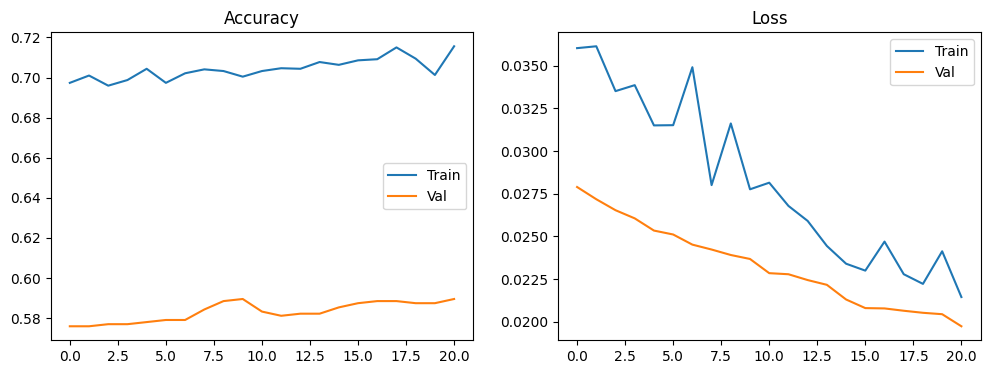

30/30 ━━━━━━━━━━━━━━━━━━━━ 192s 6s/step
ROC-AUC (macro): 0.9993

Classification Report (thr=0.5)
              precision    recall  f1-score   support

        acne       1.00      1.00      1.00       259
pigmentation       0.96      0.95      0.95        94
    wrinkles       0.97      0.98      0.97       191

   micro avg       0.98      0.98      0.98       544
   macro avg       0.98      0.97      0.97       544
weighted avg       0.98      0.98      0.98       544
 samples avg       0.56      0.56      0.56       544


===== AVERAGE (MACRO) METRICS =====
Accuracy : 0.9822
Precision: 0.9753
Recall   : 0.9740
AUC      : 0.9993


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:

# ============================================================
# CELL 5 — Evaluation (Fixed for resumed training)
# ============================================================
plt.figure(figsize=(12,4))

# --- Accuracy ---
plt.subplot(1,2,1)
plt.plot(history_ft.history['accuracy'], label="Train")
plt.plot(history_ft.history['val_accuracy'], label="Val")
plt.title("Accuracy"); plt.legend()

# --- Loss ---
plt.subplot(1,2,2)
plt.plot(history_ft.history['loss'], label="Train")
plt.plot(history_ft.history['val_loss'], label="Val")
plt.title("Loss"); plt.legend()

plt.show()


val_gen.reset()
preds = model.predict(val_gen)
y_true = val_df[CLASSES].values

roc_auc = roc_auc_score(y_true, preds, average="macro")
print(f"ROC-AUC (macro): {roc_auc:.4f}")
print("\nClassification Report (thr=0.5)")
print(classification_report(y_true, (preds>0.5).astype(int), target_names=CLASSES))


from sklearn.metrics import precision_score, recall_score, accuracy_score

# Get binary predictions
y_pred_bin = (preds > 0.5).astype(int)

# Macro (average across all labels)
macro_precision = precision_score(y_true, y_pred_bin, average='macro')
macro_recall    = recall_score(y_true, y_pred_bin, average='macro')
macro_acc       = accuracy_score(y_true, y_pred_bin)
macro_auc       = roc_auc_score(y_true, preds, average='macro')

print("\n===== AVERAGE (MACRO) METRICS =====")
print(f"Accuracy : {macro_acc:.4f}")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall   : {macro_recall:.4f}")
print(f"AUC      : {macro_auc:.4f}")



30/30 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step


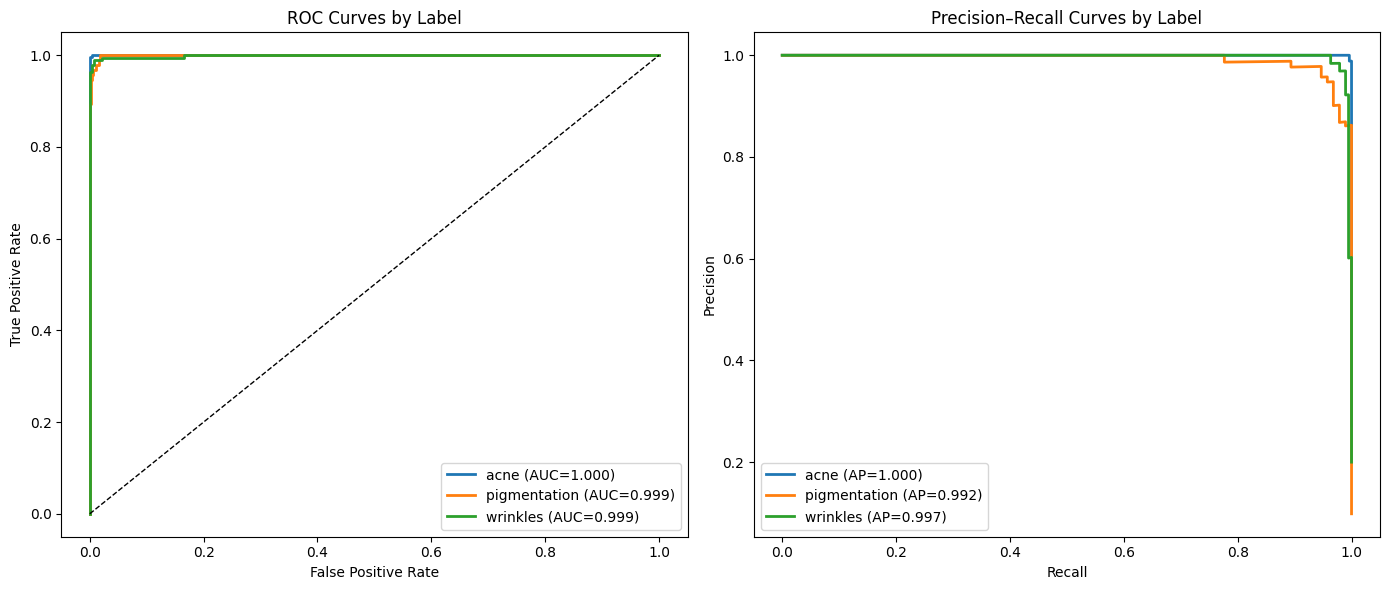

In [15]:
# ============================================================
# CELL 6 — Per-Label ROC + Precision-Recall Curves (Fixed)
# ============================================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure we have predictions
val_gen.reset()
preds = model.predict(val_gen, verbose=1)

y_true = val_df[CLASSES].values
y_pred = preds

plt.figure(figsize=(14,6))

# ----- ROC Curves -----
plt.subplot(1,2,1)
for i, c in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{c} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Label')
plt.legend(loc="lower right")

# ----- Precision–Recall Curves -----
plt.subplot(1,2,2)
for i, c in enumerate(CLASSES):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    ap = average_precision_score(y_true[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f"{c} (AP={ap:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves by Label')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [16]:
# ============================================================
# CELL 8 — Save Trained DenseNet Model
# ============================================================
model.save("/content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel_v2.keras")
print("✅ Updated model saved after resuming training.")



✅ Updated model saved after resuming training.


In [8]:
from tensorflow.keras.models import load_model

MODEL_PATH = "/content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras"
model = load_model(MODEL_PATH)

print("✅ Model loaded successfully from Drive!")


✅ Model loaded successfully from Drive!


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Recreate the callbacks
ckpt = ModelCheckpoint(
    "/content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lrred = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

print("✅ Callbacks redefined successfully!")



✅ Callbacks redefined successfully!


In [11]:
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    initial_epoch=29,
    callbacks=[ckpt, early, lrred],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 30/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6904 - loss: 0.0377
Epoch 30: val_loss improved from inf to 0.02790, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 1368s 12s/step - accuracy: 0.6905 - loss: 0.0377 - val_accuracy: 0.5759 - val_loss: 0.0279 - learning_rate: 1.0000e-05
Epoch 31/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7038 - loss: 0.0364
Epoch 31: val_loss improved from 0.02790 to 0.02718, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 967s 9s/step - accuracy: 0.7037 - loss: 0.0364 - val_accuracy: 0.5759 - val_loss: 0.0272 - learning_rate: 1.0000e-05
Epoch 32/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6856 - loss: 0.0336
Epoch 32: val_loss improved from 0.02718 to 0.02654, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_